In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions as F
import sys
import csv
from pprint import pprint 

plt.style.use('ggplot')

N = 300
batchsize = 20
for i in xrange(0, N, batchsize):
    print i

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280


In [25]:
# 確率的勾配降下法におけるミニバッチ数
batchsize = 20

# 学習の繰り返し回数
n_epoch = 10

# 中間層の数
n_units = 20


#=================================================
# csvファイルからデータを取り出し、listに格納
def set_data():

        filename = "../../../data/secondary_selection/input_data2_2"
        
        f = open('%s.csv' % filename, 'rU')
        data = csv.reader(f)

        data_set = []
        target_set = []
        for line in data:
                data_set.append(line[1:16])
                target_set.append(line[16])
        f.close()
        np_dataSet = np.array(data_set, dtype=np.float32)
        np_targetSet = np.array(target_set, dtype=np.int32)
        return np_dataSet, np_targetSet

#=================================================

data, target = set_data()

# <!--- start_debug
#print data.shape
#print target.shape
#       end_debug ----> 


# 学習用データをN個、検証用データを残りの個数と設定
# Nの値は暫定的なもの
N = 300
x_train, x_test = np.split( data, [N])  
y_train, y_test = np.split( target, [N]) 
N_test = y_test.size
#print data
#print target



In [26]:
# 多層パーセプトロンモデルの設定
# 入力 15次元、出力 2次元
model = FunctionSet(l1=F.Linear(15, n_units),
                    l2=F.Linear(n_units, n_units),
                    l3=F.Linear(n_units, n_units),
                    l4=F.Linear(n_units, 2))

# Neural net architecture
# ニューラルネットの構造
def forward(x_data, y_data, train=True ):
        x, t = Variable(x_data), Variable(y_data)
        h1 = F.dropout(F.relu(model.l1(x)), ratio=.2, train=train)
        h2 = F.dropout(F.relu(model.l2(h1)), ratio=.2, train=train)
        h3 = F.dropout(F.relu(model.l3(h2)), ratio=.2, train=train)
        y = model.l4(h3)
        # 0/1の2クラス分類なので誤差関数として、ソフトマックス関数
        # を用いて、誤差を導出
        return F.softmax_cross_entropy(y, t), F.accuracy(y, t)



In [27]:
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

train_loss = []
train_acc= []
test_loss = []
test_acc = []

l1_W = []
l2_W = []
l3_W = []
l4_W = []

count_epoch = 1
is_done = False

epoch 71
train mean loss=0.0996905440775, accuracy=0.963333324591
test  mean loss=0.0632229512721, accuracy=1.03508771512
epoch 72
train mean loss=0.0782929228619, accuracy=0.966666658719
test  mean loss=0.0659018097315, accuracy=1.04385964703
epoch 73
train mean loss=0.0765955340117, accuracy=0.98333332936
test  mean loss=0.0594981798183, accuracy=1.04385964703
epoch 74
train mean loss=0.0779416991398, accuracy=0.966666658719
test  mean loss=0.0549943768011, accuracy=1.04385964703
epoch 75
train mean loss=0.0592544381817, accuracy=0.986666663488
test  mean loss=0.058756086142, accuracy=1.04385964703
epoch 76
train mean loss=0.0748649572954, accuracy=0.973333326976
test  mean loss=0.0553522454248, accuracy=1.04385964703
epoch 77
train mean loss=0.0544023587058, accuracy=0.986666663488
test  mean loss=0.0556449565971, accuracy=1.04385964703
epoch 78
train mean loss=0.0735343712072, accuracy=0.979999995232
test  mean loss=0.0488124855002, accuracy=1.04385964703
epoch 79
train mean loss=0

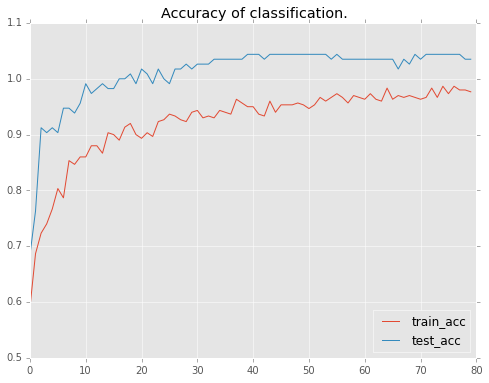

In [35]:
if is_done == True:
    count_epoch += n_epoch
    
# Learning loop
for epoch in xrange(count_epoch, count_epoch+n_epoch):
        print 'epoch', epoch

        # training
        # N個の順番をランダムに並び替える
        perm = np.random.permutation(N)
        sum_accuracy = 0
        sum_loss = 0
        # 0〜Nまでのデータをバッチサイズごとに使って学習
        for i in xrange(0, N, batchsize):
                x_batch = x_train[perm[i:i+batchsize]]
                y_batch = y_train[perm[i:i+batchsize]]

                # 勾配を初期化
                optimizer.zero_grads()
                # 順伝播させて誤差と精度を算出
                loss, acc = forward(x_batch, y_batch)
                # 誤差逆伝播で勾配を計算
                loss.backward()
                optimizer.update()
                
                sum_loss += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # 訓練データの誤差と、正解精度を表示
        print 'train mean loss={}, accuracy={}'.format(sum_loss / N, sum_accuracy / N)
                
        train_loss.append(sum_loss / N)
        train_acc.append(sum_accuracy / N)


        # evaluation
        # テストデータで誤差と、正解精度を算出し汎化性能を確認
        sum_accuracy = 0
        sum_loss     = 0
        n = 410 - N
        per = np.random.permutation(n)
        for i in xrange(0, N_test, batchsize):
                x_batch = x_test[per[i:i+batchsize]]
                y_batch = y_test[per[i:i+batchsize]]

                # 順伝播させて誤差と精度を算出
                loss, acc = forward(x_batch, y_batch, train=False)
          

                #print( cuda.to_cpu(loss.data))
                sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # テストデータでの誤差と、正解精度を表示
        print 'test  mean loss={}, accuracy={}'.format(sum_loss / N_test, sum_accuracy / N_test)
        test_loss.append( sum_loss / N_test)
        test_acc.append( sum_accuracy / N_test)
        

        
        # 学習したパラメーターを保存
        l1_W.append(model.l1.W)
        l2_W.append(model.l2.W)
        l3_W.append(model.l3.W)
        l4_W.append(model.l4.W)
        
        #l1_W = np.append( l1_W, model.l1.W)
        
                      
        #pprint(vars(model.l1))
        #pprint(model.l1.W[0:2])

        # 精度と誤差をグラフ描画
plt.figure(figsize=(8,6))
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(test_acc)), test_acc)
plt.legend(["train_acc","test_acc"],loc=4)
plt.title("Accuracy of classification.")
plt.plot()

is_done = True

In [42]:
# 学習したパラメータを出力
#print l1_W[0]

#print l2_W
#print l3_W

l1 = l1_W[0].T
l2 = l2_W[0].T
l3 = l3_W[0].T
l4 = l4_W[0].T


param = l1.dot(l2).dot(l3).dot(l4)

print param

[[  0.31144959  -0.4000473 ]
 [ -4.75606537   6.32488441]
 [ -2.56400204   2.87870574]
 [  0.60563874  -0.32395741]
 [ -0.74024415   1.54552341]
 [ -1.19727945   2.07823539]
 [ -0.02147472  -0.47758412]
 [ -1.07075405   1.66394055]
 [ -7.99542284   9.84941864]
 [-13.99386024  17.10969543]
 [ -1.52038181   1.76278055]
 [ -1.93918741   2.27651668]
 [  0.13451995  -0.10531852]
 [ -3.42047596   4.47207451]
 [ -9.07000923  11.17031002]]


In [8]:
pprint(vars(model.l1))
pprint(vars(model.l2))

{'W': array([[ 0.69221675,  0.97149658],
       [-0.35120749, -0.74204099],
       [-0.17986614, -0.48646429],
       [-0.12201571,  0.63741136]], dtype=float32),
 'b': array([ 0.41029909,  0.29600775, -0.2109804 , -0.00146954], dtype=float32),
 'gW': array([[-0.02851585, -0.01814253],
       [ 0.06960598,  0.04130198],
       [-0.00750261, -0.00472702],
       [-0.03389475, -0.01394051]], dtype=float32),
 'gb': array([-0.01186311, -0.13013972,  0.01142588, -0.01415433], dtype=float32)}
{'W': array([[-1.0924716 ,  1.10244846,  0.2408329 , -0.24381626],
       [ 0.33471557, -0.44035417,  0.45139486,  0.75798011]], dtype=float32),
 'b': array([ 0.02525388, -0.02525389], dtype=float32),
 'gW': array([[ 0.02959166, -0.06065036, -0.00589033,  0.00470932],
       [-0.02959165,  0.06065036,  0.00589033, -0.00470932]], dtype=float32),
 'gb': array([-0.05731631,  0.05731632], dtype=float32)}
